<img src="elo.jpg" alt="Alt text that describes the graphic" title="Title text" />

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
from scipy import stats

<h1><center>Exploratory Data Analysis</center></h1>

1. Import libraries
2. Read files in Pandas Dataframe
3. Examine data, perform small data cleaning steps
4. Check for null values
5. Better understand the data through novel vizualizations
***

In [2]:
train =  pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
test.shape

(123623, 5)

In [4]:
hist_trans = pd.read_csv('historical_transactions.csv')

In [5]:
new_merchants = pd.read_csv('new_merchant_transactions.csv')

In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


1. The target value appears to be in logarithmic form
2. The features are all anomymous besides the registration date
3. There are few features to predict the loyalty score on

In [7]:
train.isnull().values.any() # Dataframe contains no null values, neat! 

False

In [8]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [9]:
for df in [train, test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['year'] = df['first_active_month'].dt.year
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days

**Converting the first active month column into datetime format, and seperating the year and month into seperate columns so that we can inspect if theres any significance to month a user began**

In [10]:
train.head(2)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,396


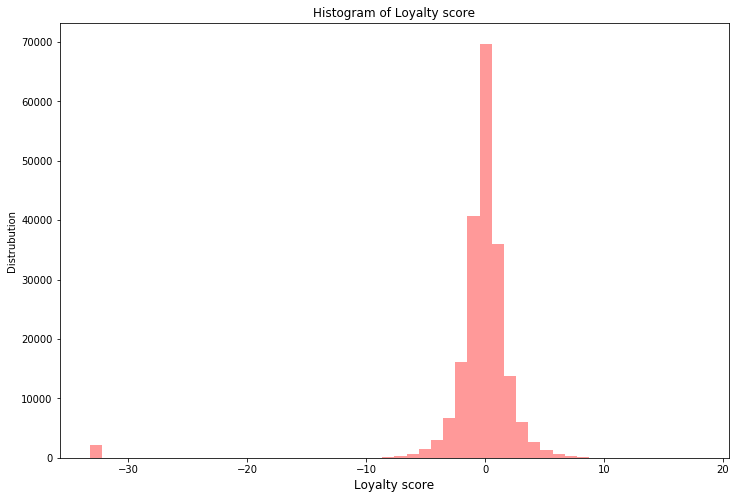

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(train.target.values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.ylabel('Distrubution')
plt.show()

In [12]:
low_target = train.target < -30
low_target.value_counts()

False    199710
True       2207
Name: target, dtype: int64

**1% of the observations in the training set have an outlier targrt value of -33. Why is there a spike in target values at -33 and no where else. Perhaps there is a reason for this. But for model prediction these values maybe should be excluded**

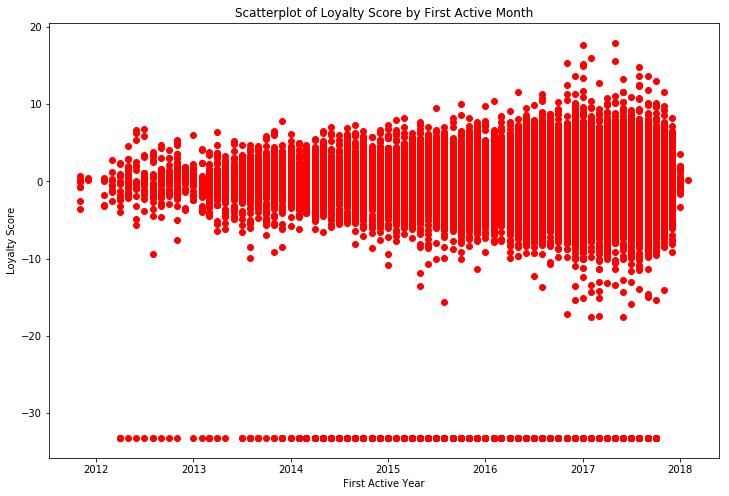

In [13]:
plt.figure(figsize=(12,8))
plt.plot_date(data=train, x='first_active_month', y='target', color= 'red')
plt.title('Scatterplot of Loyalty Score by First Active Month')
plt.xlabel('First Active Year')
plt.ylabel('Loyalty Score')
plt.show()

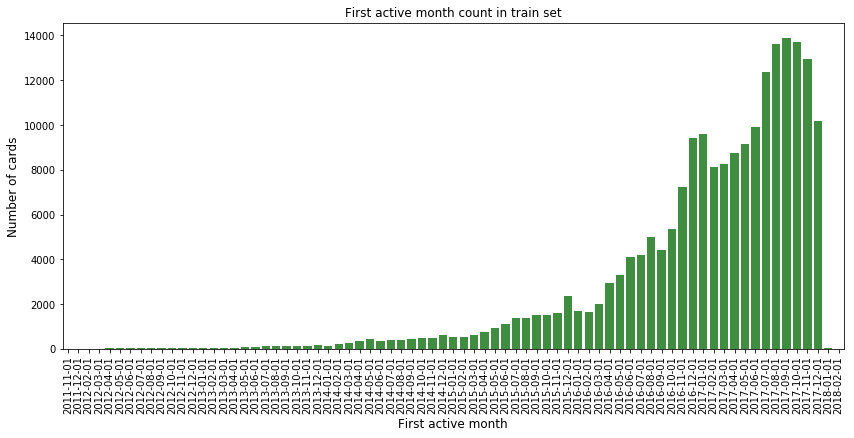

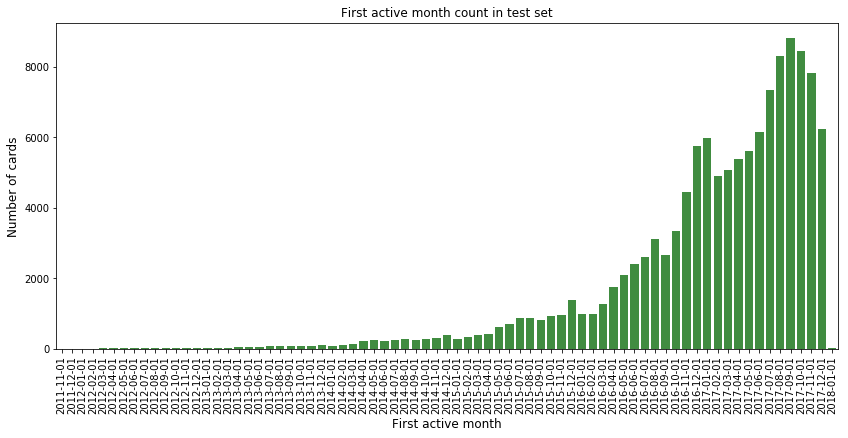

In [14]:
cnt_srs = train['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in train set")
plt.show()

cnt_srs = test['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title("First active month count in test set")
plt.show()

### The distrubution between the two sets appear similar <br>

In [15]:
hist_trans.head(3) #Contains information about the cusotmer transaction

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [16]:
new_merchants.head(3) 
# contains the transactions at new merchants (merchant_ids that this particular card_id has not yet visited) 
# over a period of two months.

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14


#  **Column Descriptions**

***
card_id - Card identifier<br>

month_lag - month lag to reference date<br>

purchase_date - Purchase date<br>

authorized_flag - 'Y' if approved, 'N' if denied<br>

category_3 - anonymized category<br>

installments - number of installments of purchase<br>

category_1 - anonymized category<br>

merchant_category_id - Merchant category identifier (anonymized )<br>

subsector_id - Merchant category group identifier (anonymized )<br>

merchant_id - Merchant identifier (anonymized)<br>

purchase_amount - Normalized purchase amount<br>

city_id - City identifier (anonymized )<br>

state_id - State identifier (anonymized )<br>

category_2 - anonymized category<br>


In [17]:
hist_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [18]:
new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


<h1><center>Data Cleaning & Transformation</center></h1> 

***

In [19]:
hist_trans['authorized_flag'] = hist_trans['authorized_flag'].map({'Y':1, 'N':0})
hist_trans['category_1'] = hist_trans['category_1'].map({'Y':1, 'N':0})
hist_trans['category_3'] = hist_trans['category_3'].map({'A':1, 'B':2, 'C':3})
hist_trans = hist_trans.dropna()

new_merchants['authorized_flag'] = new_merchants['authorized_flag'].map({'Y':1, 'N':0})
new_merchants['category_1'] = new_merchants['category_1'].map({'Y':1, 'N':0})
new_merchants['category_3'] = new_merchants['category_3'].map({'A':1, 'B':2, 'C':3})
new_merchants = new_merchants.dropna()

hist_and_new = [hist_trans, new_merchants] 
Transactions = pd.concat(hist_and_new, keys=['Not_new', 'New_Merchant'])

# Created dummy variables for the string or category data type features 
# Dropped observations with missing values since there are few
# Concat the two files into one pandas dataframe

In [20]:
def aggregate_historical_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max'],
        'category_1': ['sum', 'mean'],
        'category_2': ['sum', 'mean'],
        'category_3': ['sum', 'mean']

        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True) 
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

# Performs a large groupby, based off each unique customer ID, creating new statistical features 
# based off of existing features for our data to train on. 

In [21]:
grouped_transactions = aggregate_historical_transactions(Transactions)

#Used function do add features to Transactions, which was origininally the historical and new transaction datasets

new_train = pd.merge(train, grouped_transactions, on='card_id', how='left')
new_test = pd.merge(test, grouped_transactions, on='card_id', how='left')

#Merged these with the training and testing datasets

new_train = new_train.dropna()

#Double checking that all NAN observations are dropped.

In [22]:
new_train.head(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,elapsed_time,hist_transactions_count,...,hist_installments_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max,hist_category_1_sum,hist_category_1_mean,hist_category_2_sum,hist_category_2_mean,hist_category_3_sum,hist_category_3_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2017,6,245,277.0,...,0.119513,26427897.0,-8.0,2.0,0.0,0.0,289.0,1.043321,281.0,1.014440
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,2017,1,396,323.0,...,1.377200,38672324.0,-12.0,2.0,0.0,0.0,323.0,1.000000,705.0,2.182663
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,2016,8,549,44.0,...,0.000000,40814509.0,-13.0,2.0,0.0,0.0,204.0,4.636364,44.0,1.000000


<h1><center>Validation Set</center></h1> 

1. Create a validation set from the training set <br>
2. Set it to a different time frame from the remaining training data in this case <br>
3. Use __[Featexp](https://github.com/abhayspawar/featexp)__ to examine the distbrution of the other features <br>
   as well as to compare the trends the features display with the target variable: loyalty score.
4. Use __[Featexp](https://github.com/abhayspawar/featexp)__ to then examine the trend correlation between the training <br>
   data and the validation data. This will help to determine how well the feature's impact on the loyalty score holds true 
   no matter how diverse (in our example how long ago the customer first signed up) will be.
5. Limit the features to use on our machine learning model to those with high trend correlations between <br>
   the training and validation data.

***

In [23]:
valid_mask = (new_train.elapsed_time < 100) | (new_train.elapsed_time > 800)
valid_mask.value_counts()

# Our validation data will be customers who have been users for less than 100 days and over 800 days, which is 39,837 users

False    157778
True      39837
Name: elapsed_time, dtype: int64

In [24]:
valid = new_train[valid_mask]
valid.shape #Sanity check

(39837, 33)

In [25]:
train2_mask = (new_train.elapsed_time >= 100) & (new_train.elapsed_time <= 800)
train2 = new_train[train2_mask]
train2.shape #sanity check

#The remaining values are our training data for this analysis step

(157778, 33)

card_id is categorical. Categorical features not supported yet.
                                         Plots for feature_1                                          
                                           Train data plots                                           


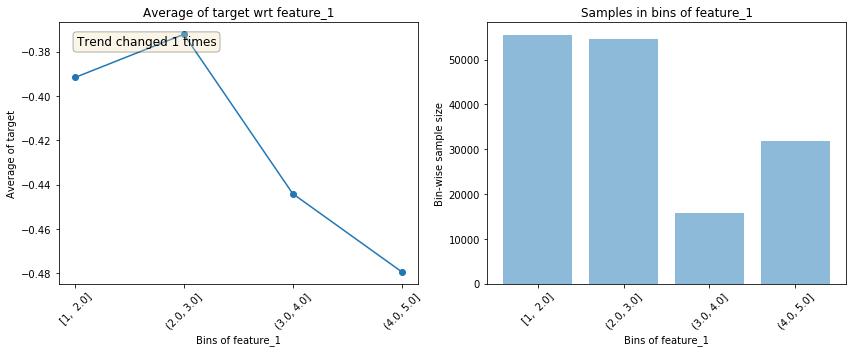

                                           Test data plots                                            


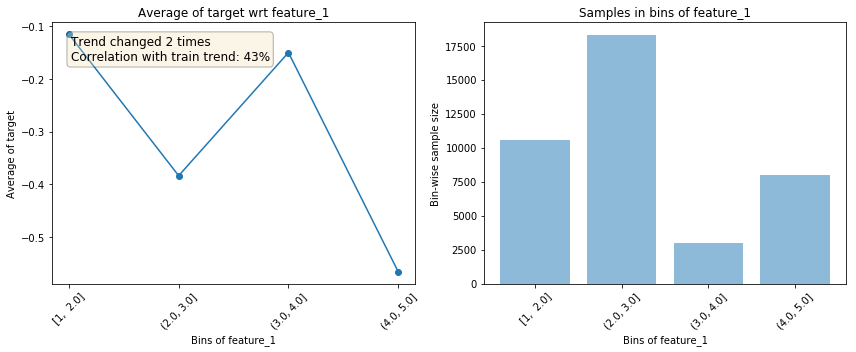

--------------------------------------------------------------------------------------------------------------


                                         Plots for feature_2                                          
                                           Train data plots                                           


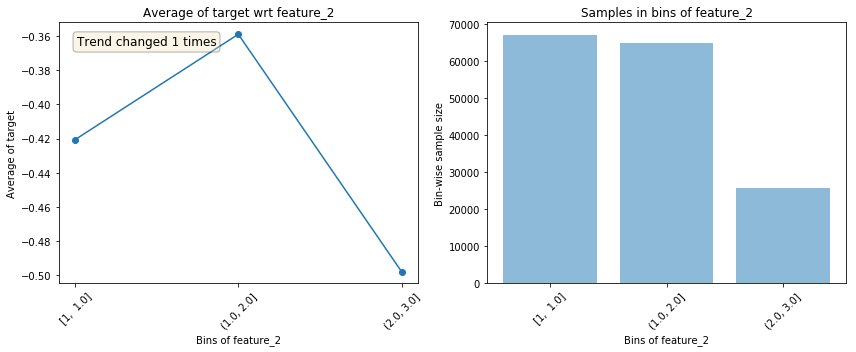

                                           Test data plots                                            


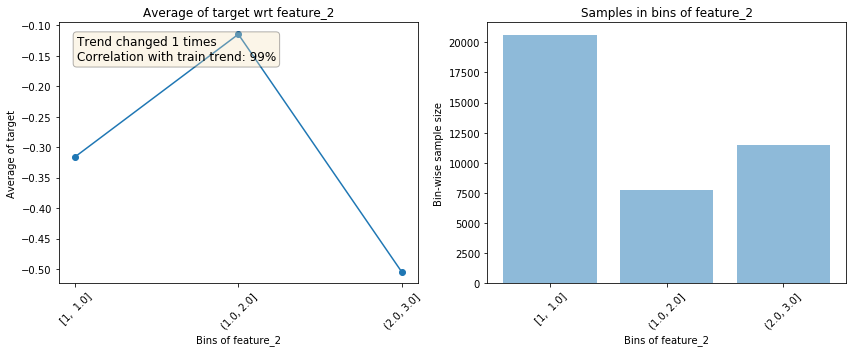

--------------------------------------------------------------------------------------------------------------


                                         Plots for feature_3                                          
                                           Train data plots                                           


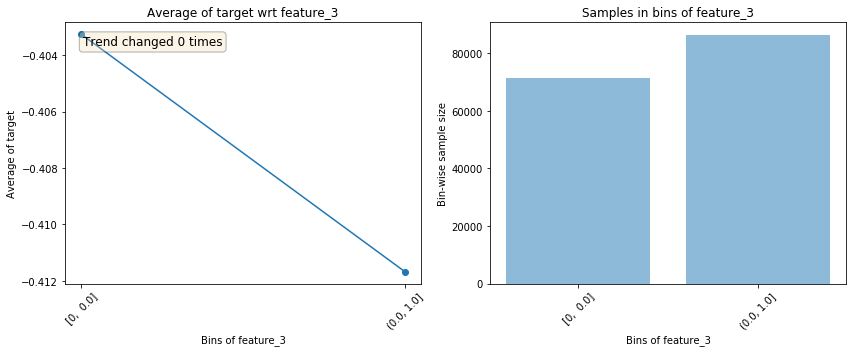

                                           Test data plots                                            


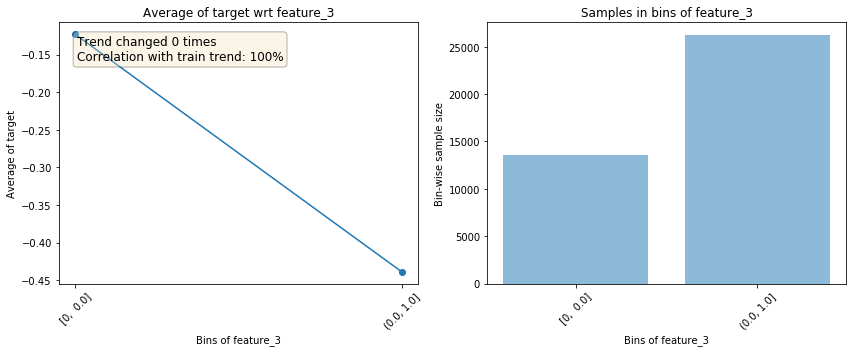

--------------------------------------------------------------------------------------------------------------


                                            Plots for year                                            
                                           Train data plots                                           


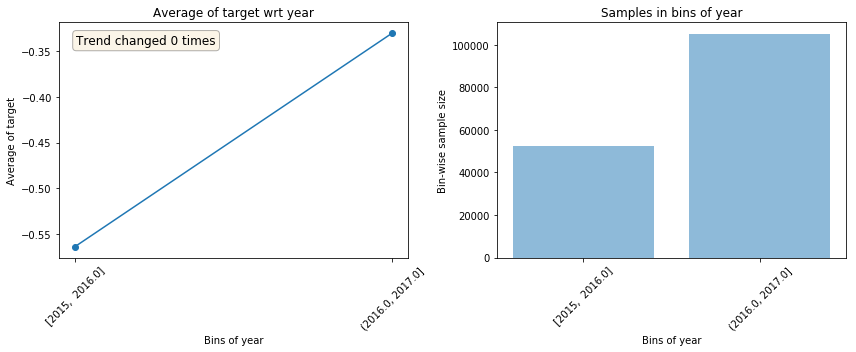

                                           Test data plots                                            


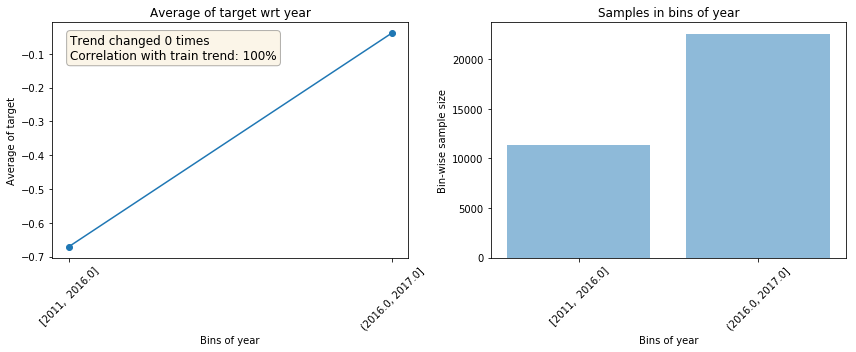

--------------------------------------------------------------------------------------------------------------


                                           Plots for month                                            
                                           Train data plots                                           


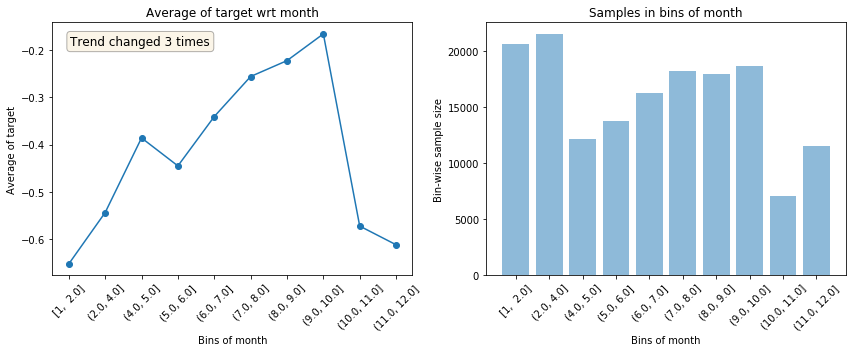

                                           Test data plots                                            


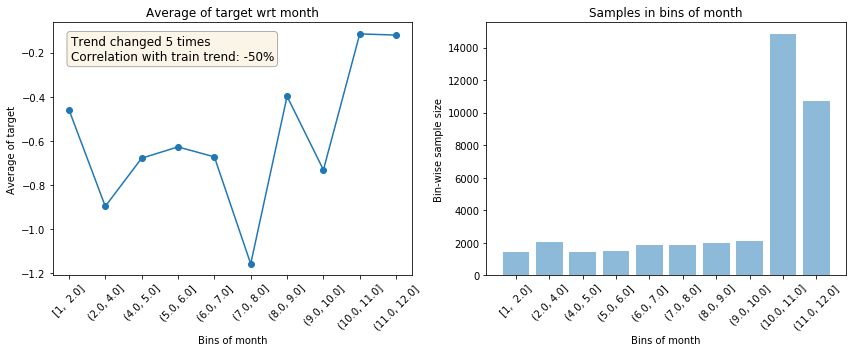

--------------------------------------------------------------------------------------------------------------


                                        Plots for elapsed_time                                        
Only one bin created for elapsed_time. Correlation can't be calculated
                                           Train data plots                                           


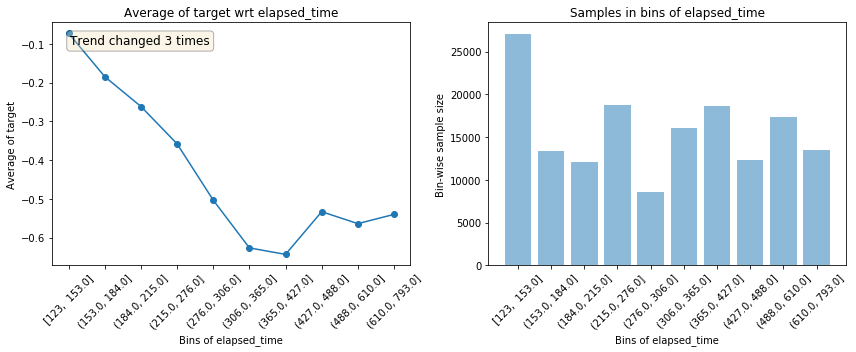

                                           Test data plots                                            


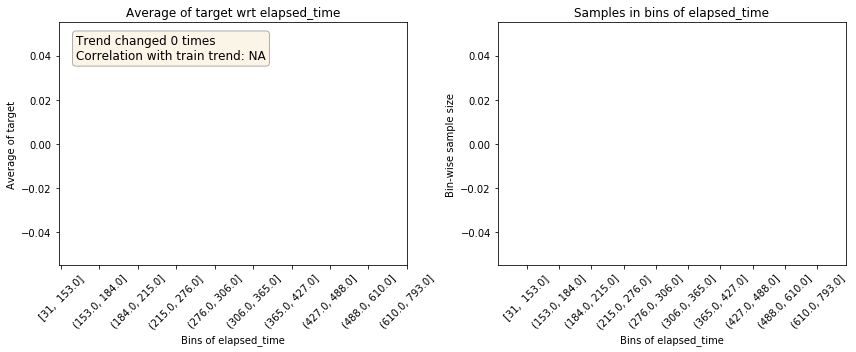

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_transactions_count                                   
                                           Train data plots                                           


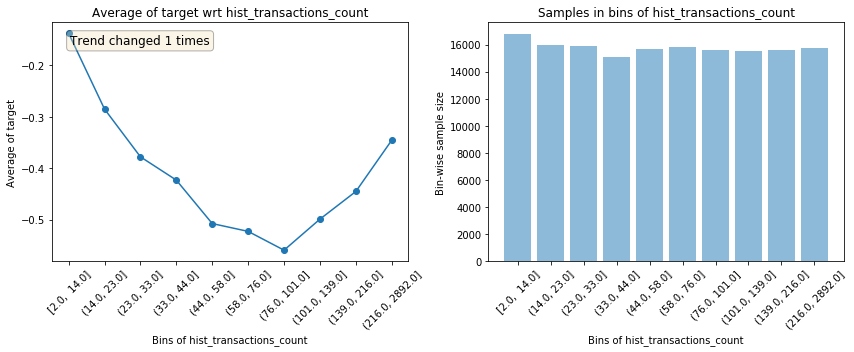

                                           Test data plots                                            


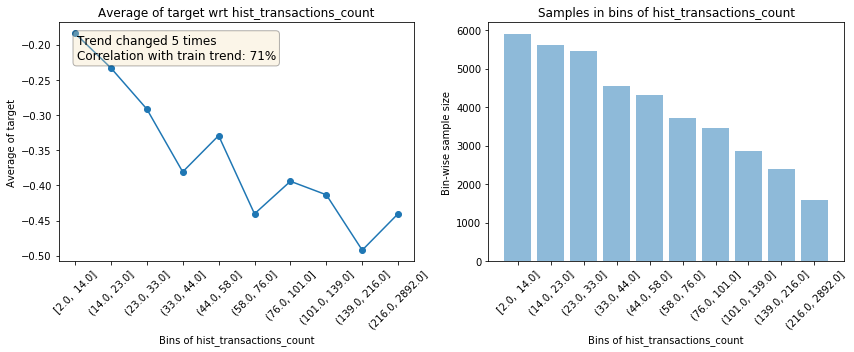

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_authorized_flag_sum                                  
                                           Train data plots                                           


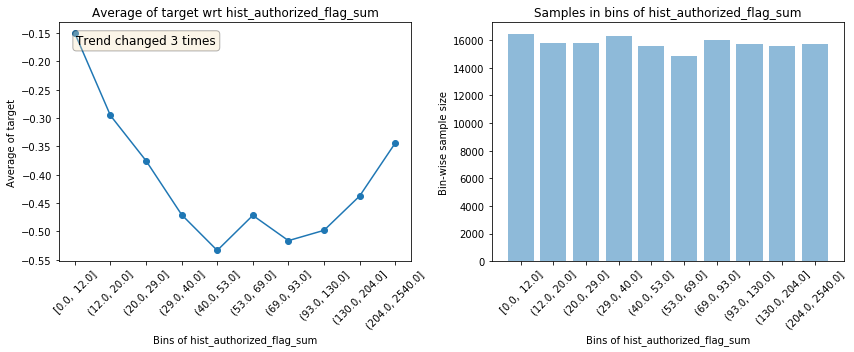

                                           Test data plots                                            


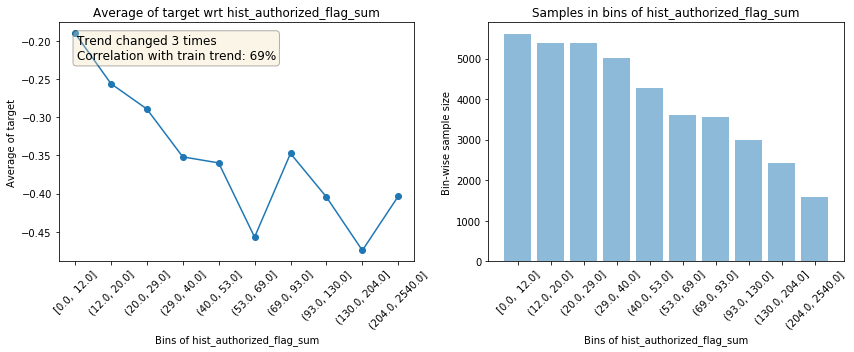

--------------------------------------------------------------------------------------------------------------


                                 Plots for hist_authorized_flag_mean                                  
                                           Train data plots                                           


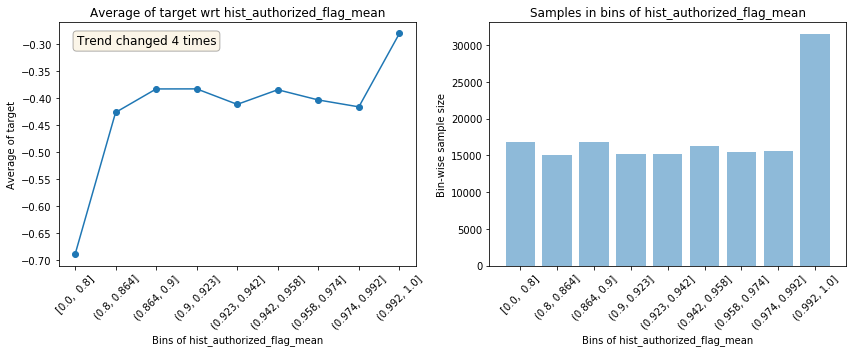

                                           Test data plots                                            


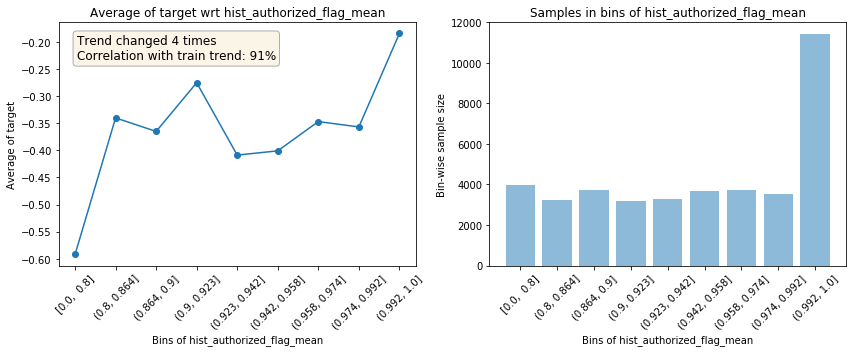

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_merchant_id_nunique                                  
                                           Train data plots                                           


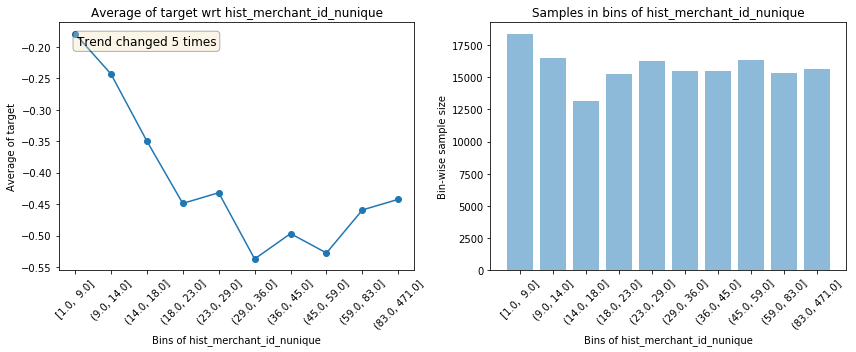

                                           Test data plots                                            


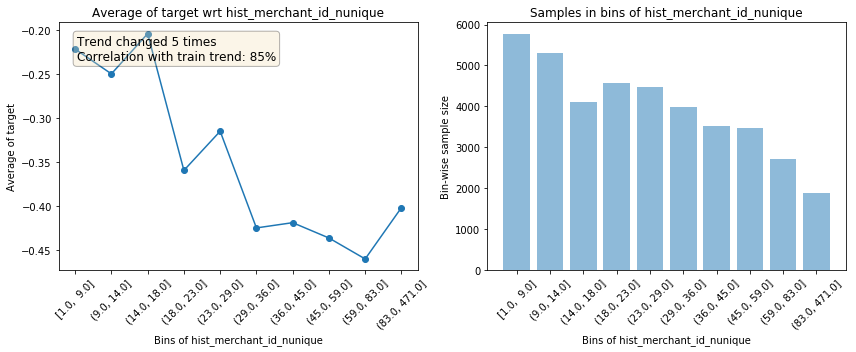

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_city_id_nunique                                    
                                           Train data plots                                           


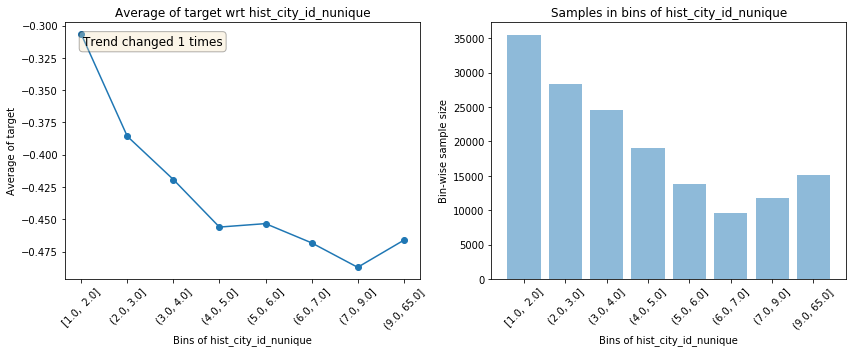

                                           Test data plots                                            


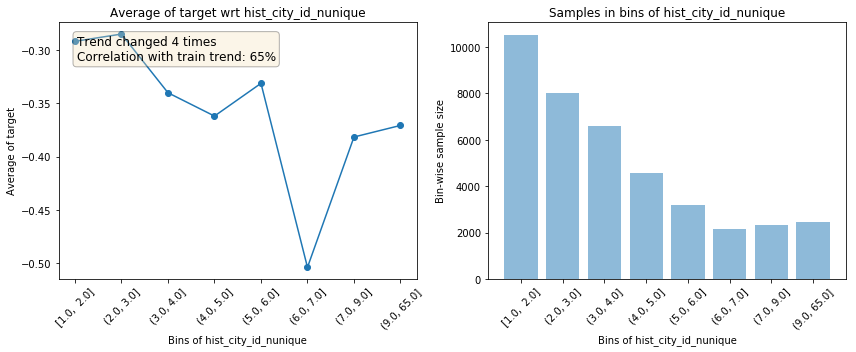

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_sum                                  
                                           Train data plots                                           


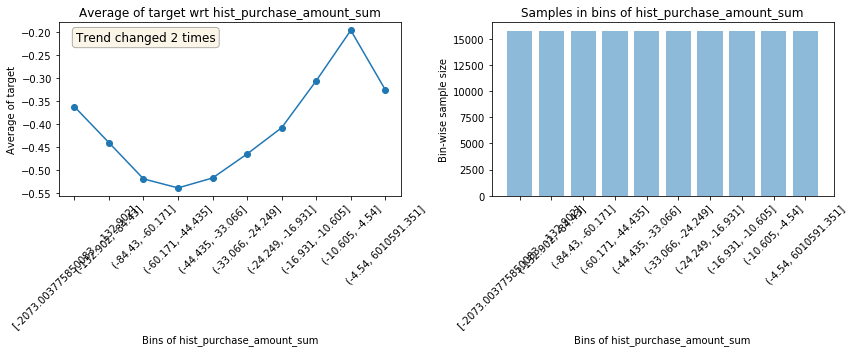

                                           Test data plots                                            


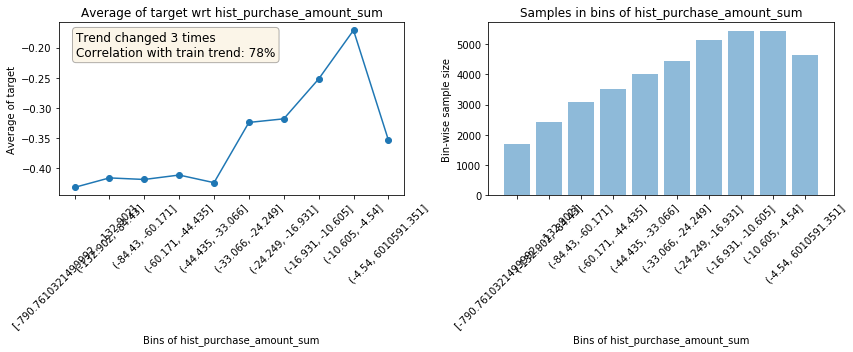

--------------------------------------------------------------------------------------------------------------


                                Plots for hist_purchase_amount_median                                 
                                           Train data plots                                           


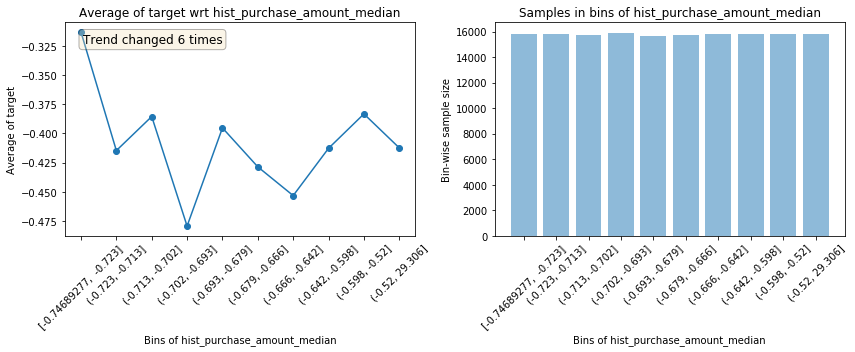

                                           Test data plots                                            


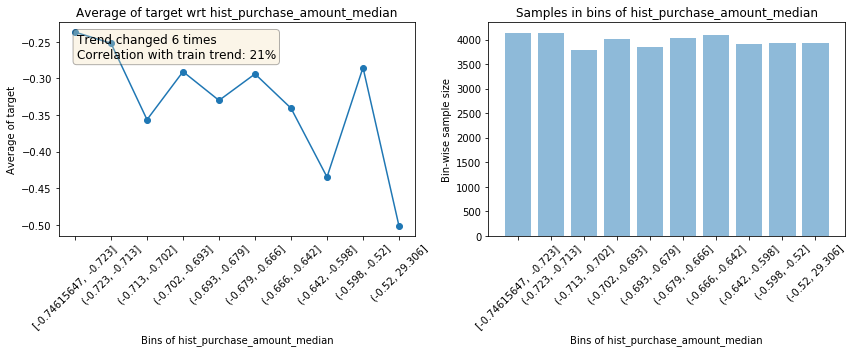

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_max                                  
                                           Train data plots                                           


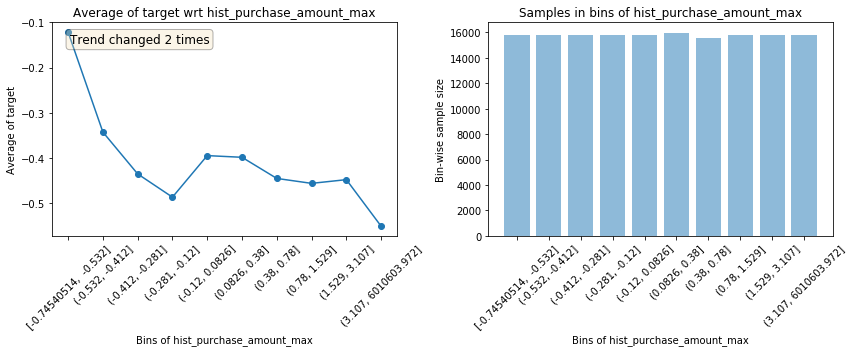

                                           Test data plots                                            


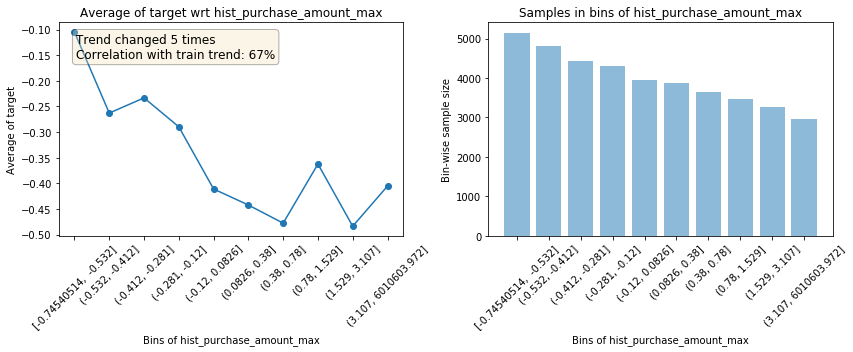

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_min                                  
                                           Train data plots                                           


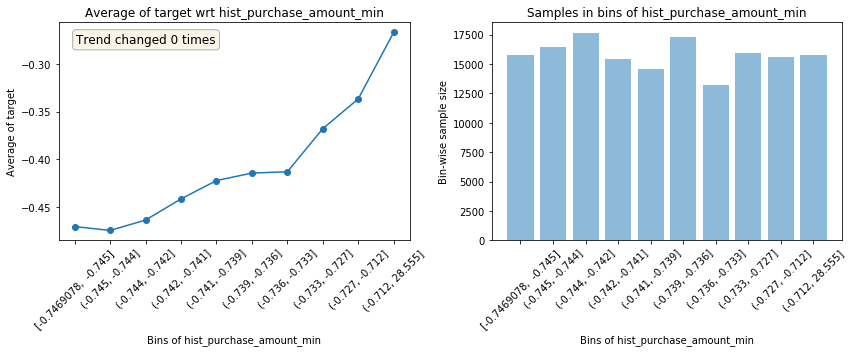

                                           Test data plots                                            


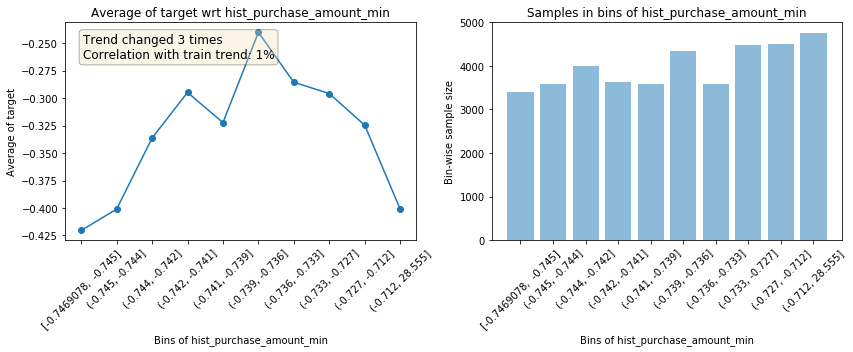

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_purchase_amount_std                                  
                                           Train data plots                                           


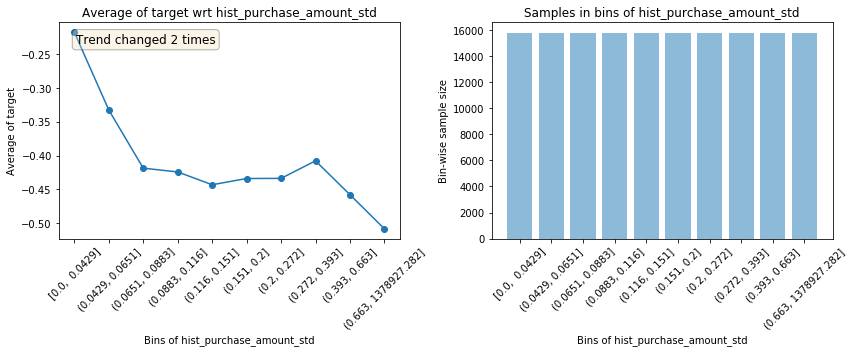

                                           Test data plots                                            


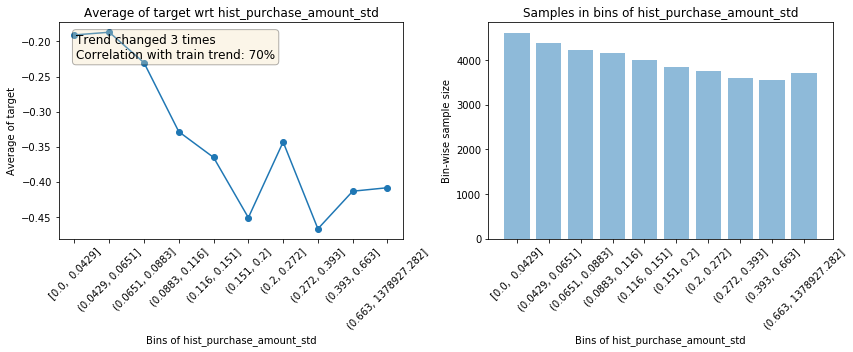

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_sum                                    
                                           Train data plots                                           


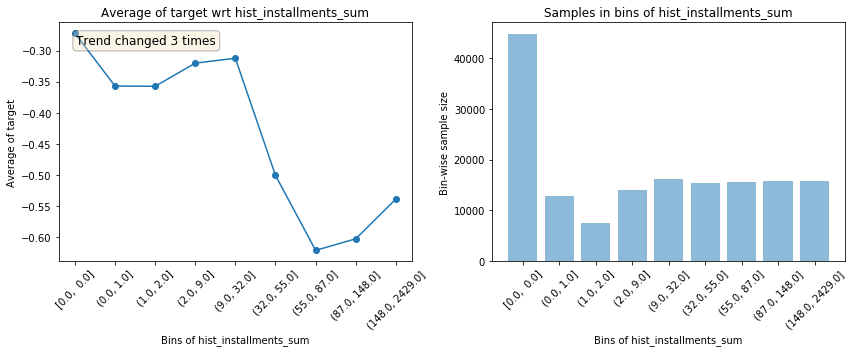

                                           Test data plots                                            


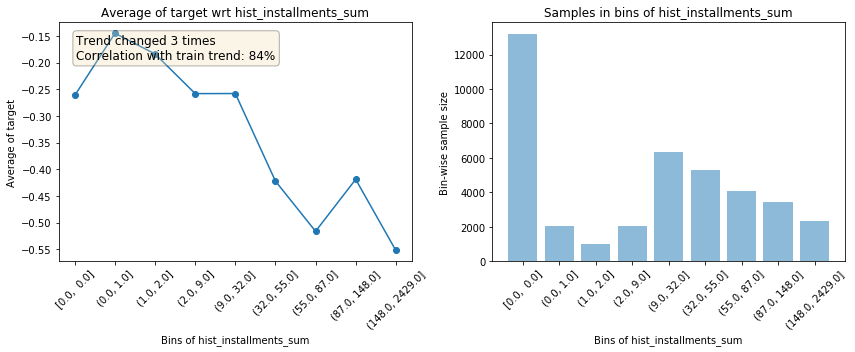

--------------------------------------------------------------------------------------------------------------


                                  Plots for hist_installments_median                                  
                                           Train data plots                                           


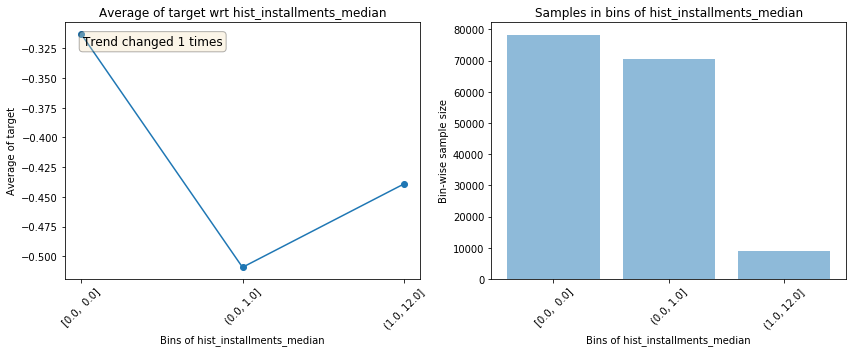

                                           Test data plots                                            


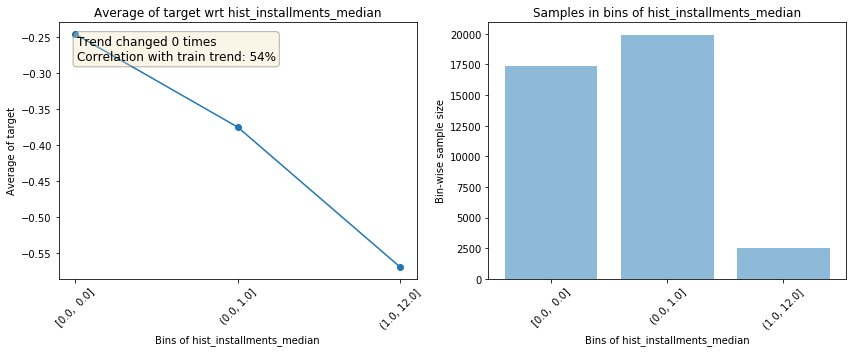

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_max                                    
                                           Train data plots                                           


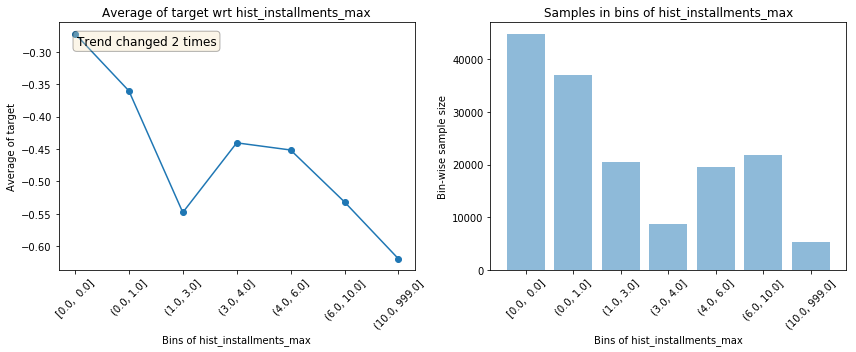

                                           Test data plots                                            


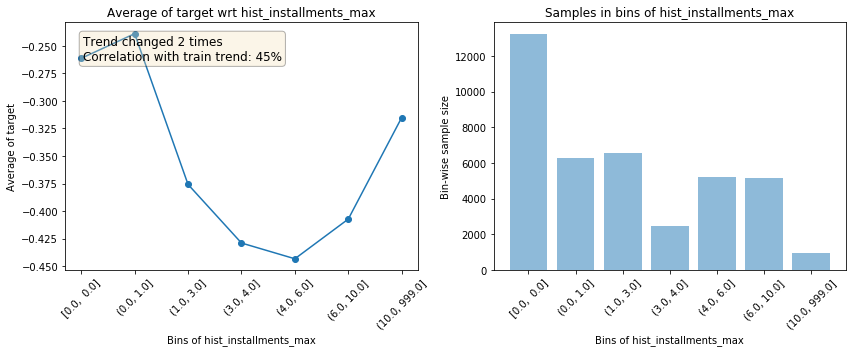

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_min                                    
                                           Train data plots                                           


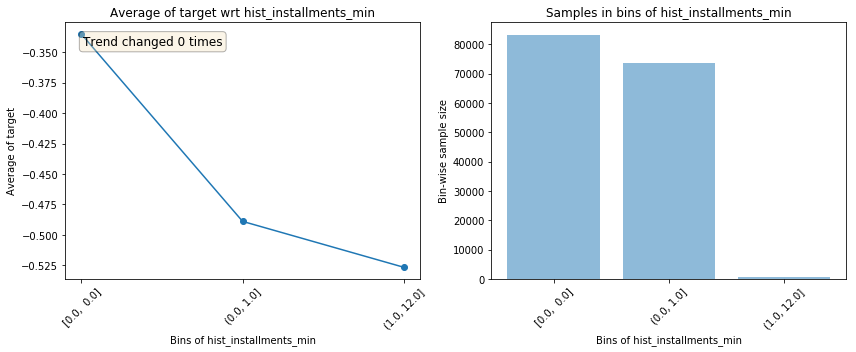

                                           Test data plots                                            


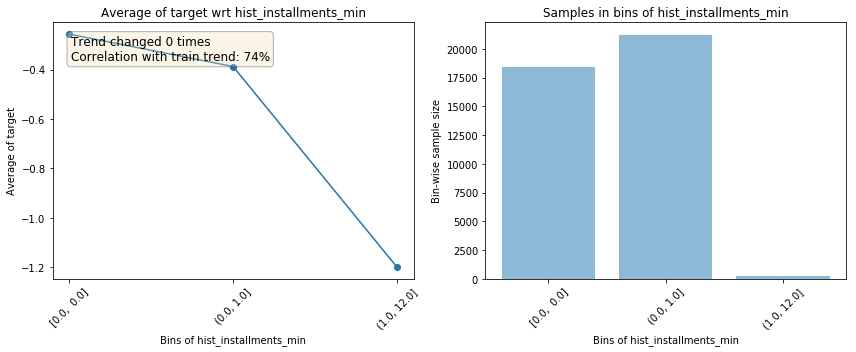

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_installments_std                                    
                                           Train data plots                                           


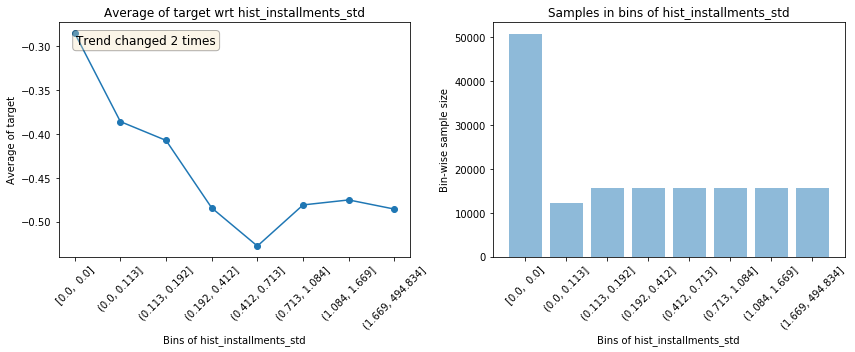

                                           Test data plots                                            


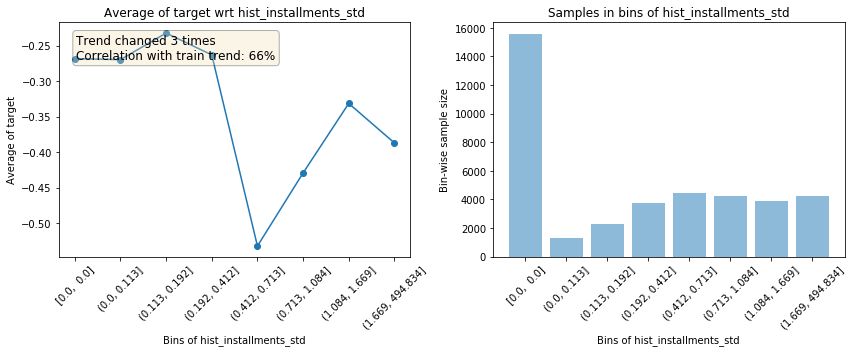

--------------------------------------------------------------------------------------------------------------


                                   Plots for hist_purchase_date_ptp                                   
                                           Train data plots                                           


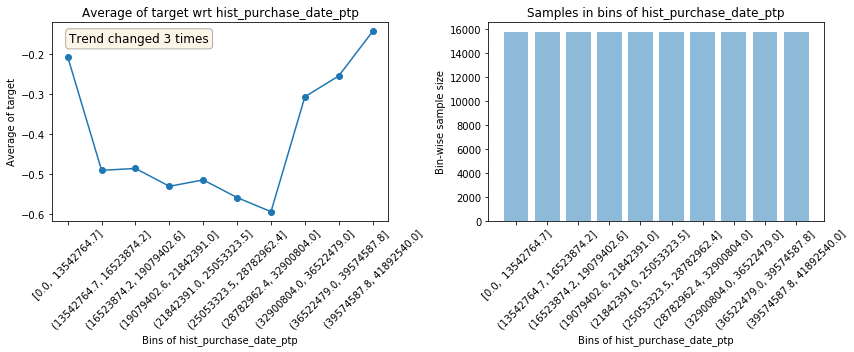

                                           Test data plots                                            


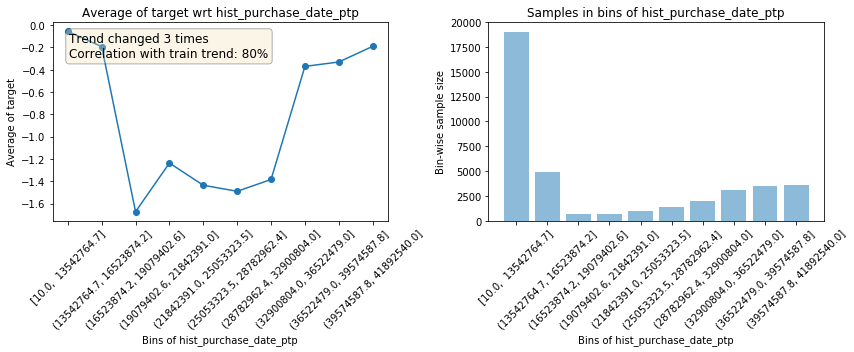

--------------------------------------------------------------------------------------------------------------


                                     Plots for hist_month_lag_min                                     
                                           Train data plots                                           


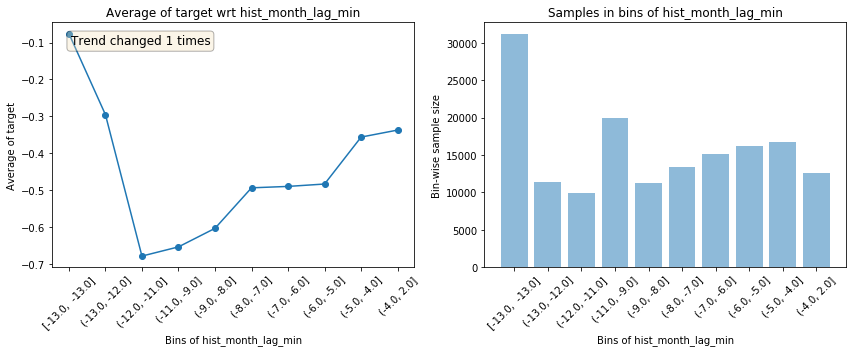

                                           Test data plots                                            


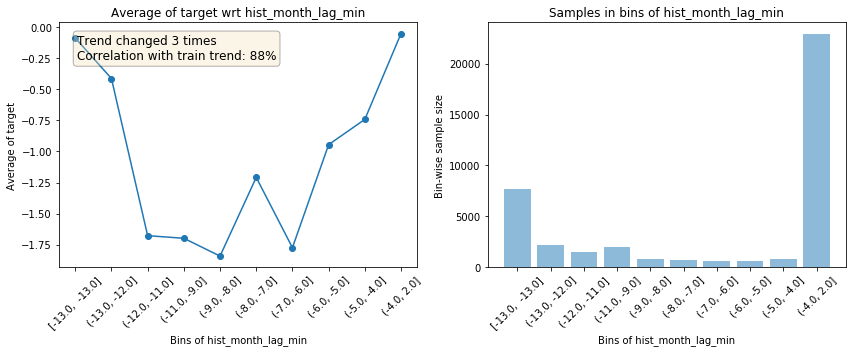

--------------------------------------------------------------------------------------------------------------


                                     Plots for hist_month_lag_max                                     
                                           Train data plots                                           


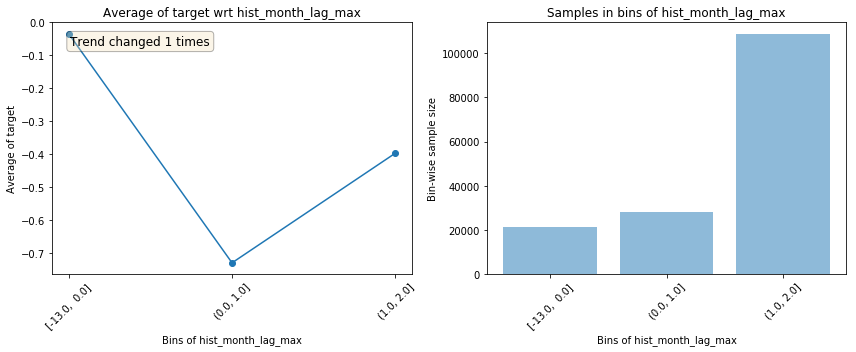

                                           Test data plots                                            


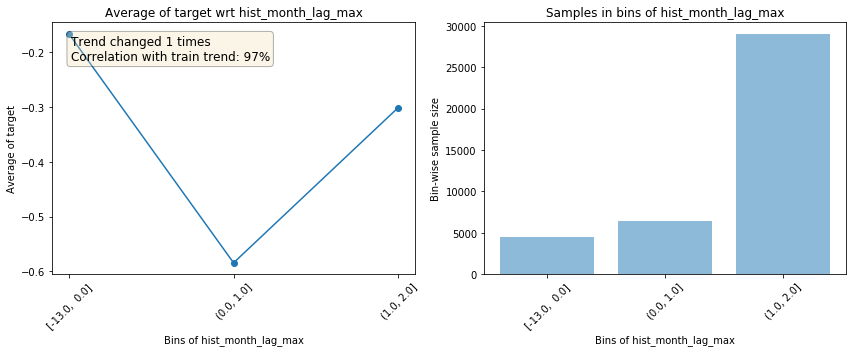

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_1_sum                                     
Only one bin created for hist_category_1_sum. Correlation can't be calculated
                                           Train data plots                                           


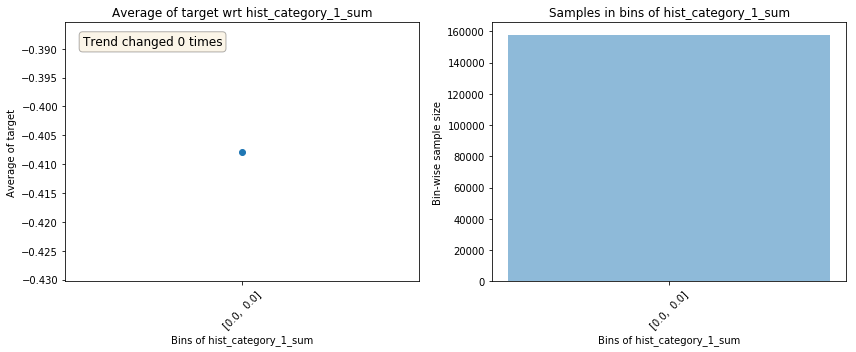

                                           Test data plots                                            


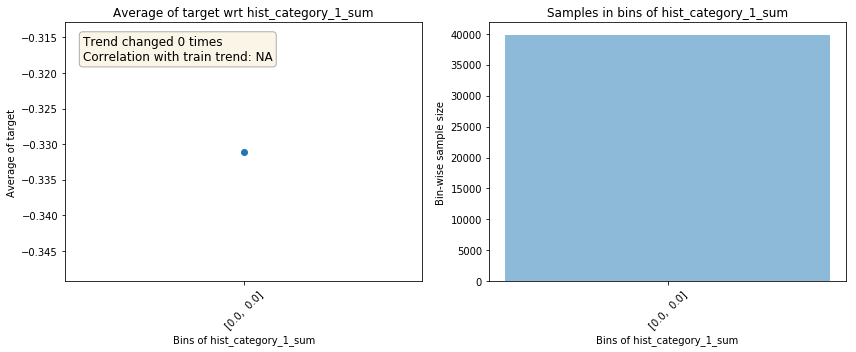

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_1_mean                                    
Only one bin created for hist_category_1_mean. Correlation can't be calculated
                                           Train data plots                                           


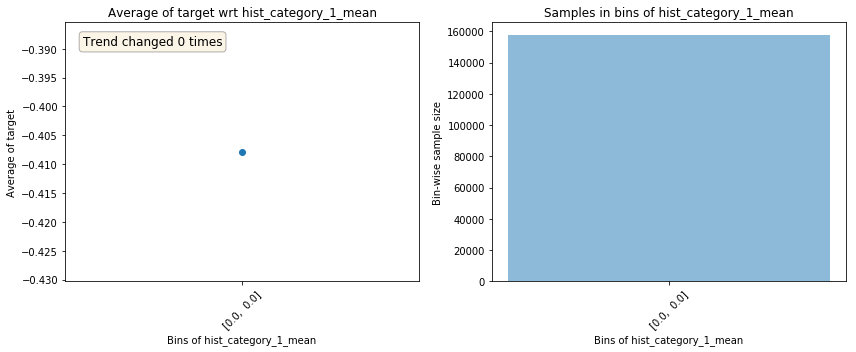

                                           Test data plots                                            


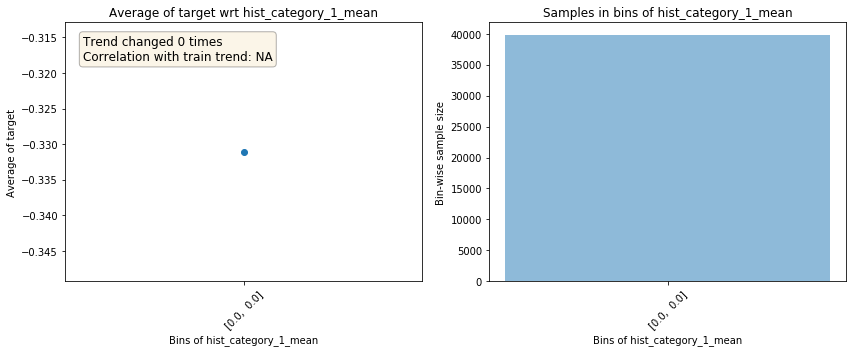

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_2_sum                                     
                                           Train data plots                                           


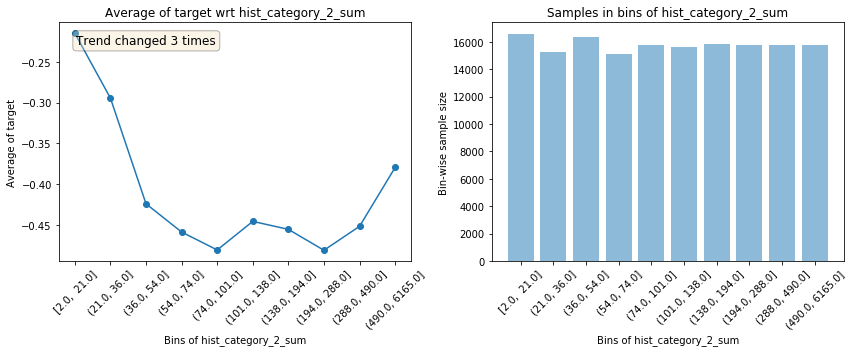

                                           Test data plots                                            


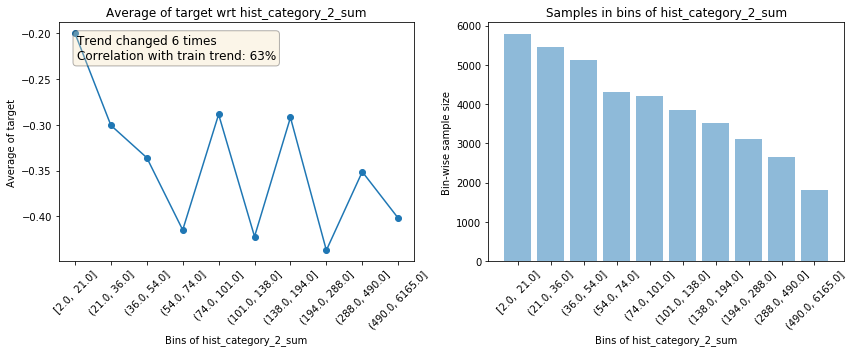

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_2_mean                                    
                                           Train data plots                                           


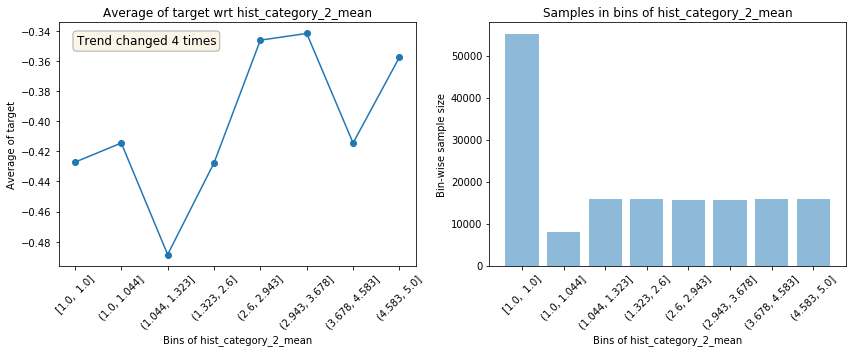

                                           Test data plots                                            


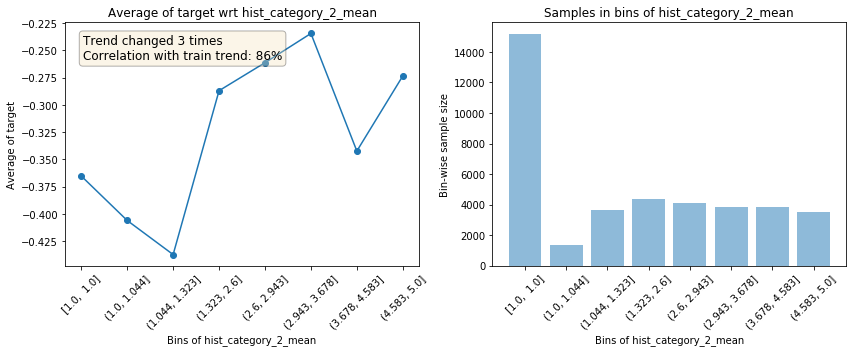

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_3_sum                                     
                                           Train data plots                                           


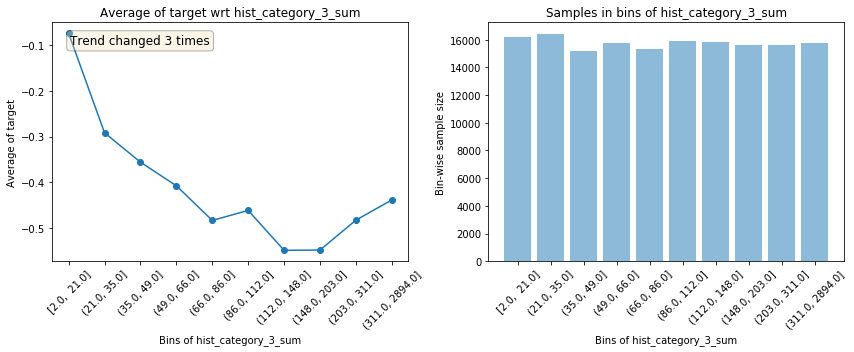

                                           Test data plots                                            


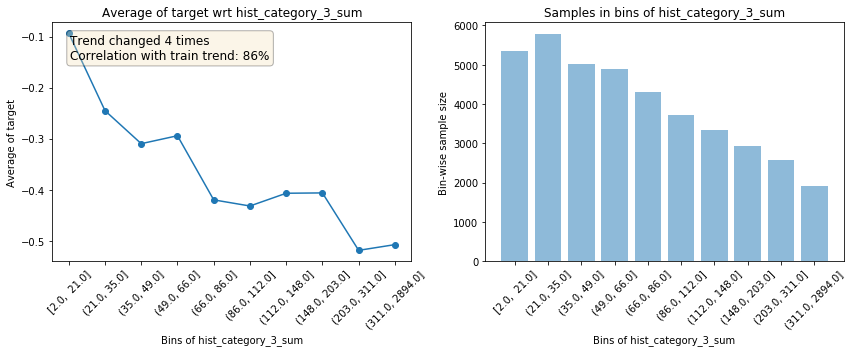

--------------------------------------------------------------------------------------------------------------


                                    Plots for hist_category_3_mean                                    
                                           Train data plots                                           


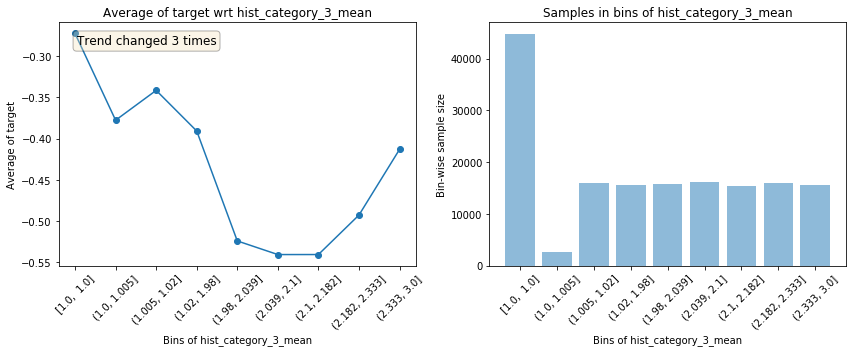

                                           Test data plots                                            


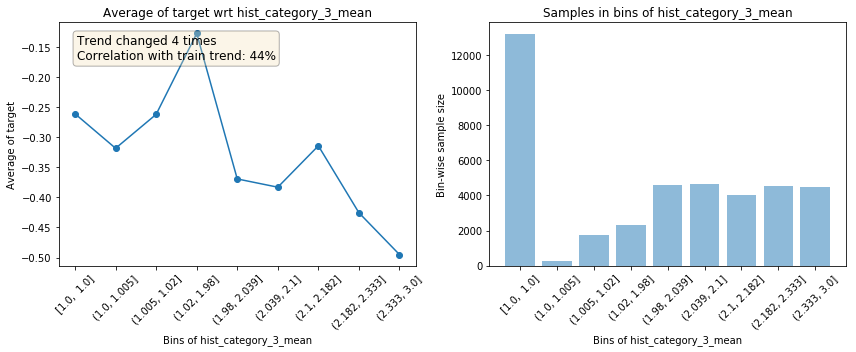

--------------------------------------------------------------------------------------------------------------




In [26]:
from featexp import get_univariate_plots


get_univariate_plots(data=train2, #Doesn't accept non-integer data types
                     target_col='target', data_test=valid, 
                     features_list=[
                         
       'card_id', 'feature_1', 'feature_2', 'feature_3',
       'year', 'month', 'elapsed_time', 'hist_transactions_count',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_merchant_id_nunique', 'hist_city_id_nunique',
       'hist_purchase_amount_sum', 'hist_purchase_amount_median',
       'hist_purchase_amount_max', 'hist_purchase_amount_min',
       'hist_purchase_amount_std', 'hist_installments_sum',
       'hist_installments_median', 'hist_installments_max',
       'hist_installments_min', 'hist_installments_std',
       'hist_purchase_date_ptp', 'hist_month_lag_min', 'hist_month_lag_max',
       'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_sum',
       'hist_category_2_mean', 'hist_category_3_sum', 'hist_category_3_mean'
                         
                     ], bins=10)

In [27]:
from featexp import get_trend_stats
stats = get_trend_stats(data=train2.drop('first_active_month', axis=1),
                        target_col='target', 
                        data_test=valid.drop('first_active_month', axis=1))

Only one bin created for elapsed_time. Correlation can't be calculated
Only one bin created for hist_category_1_sum. Correlation can't be calculated
Only one bin created for hist_category_1_mean. Correlation can't be calculated
Categorical features ['card_id'] ignored. Categorical features not supported yet.
Returning stats for all numeric features


In [28]:
stats = stats.sort_values(by='Trend_correlation', ascending=False)
stats

,Feature,Trend_changes,Trend_changes_test,Trend_correlation
2,feature_3,0,0,1.000000
3,year,0,0,1.000000
1,feature_2,1,1,0.996557
23,hist_month_lag_max,1,1,0.974305
8,hist_authorized_flag_mean,4,4,0.914882
22,hist_month_lag_min,1,3,0.882759
27,hist_category_2_mean,4,3,0.862556
28,hist_category_3_sum,3,4,0.860611
9,hist_merchant_id_nunique,5,5,0.856481
16,hist_installments_sum,3,3,0.845549


In [29]:
top15 = stats.Feature.iloc[0:15]
top15 = top15.values
top15

X_train_15 = new_train[top15] #Limited the training data to the features that made 
                              #it in the top 15 when it came to trend correlation
y_train = new_train.target    #Target Value

X_train_15 = new_train[top15]

y_train = new_train.target
X_test_15 = new_test[top15] # Same for test set

<h1><center>Variance Inflation Factor</center></h1> 

Use __[Variance Inflation Factor](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)__ which  displays the level of multicolinearity between the features. This is helpful in eliminating features that are causing the same  variation in a dataset.

In [30]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_15.values, i) for i in range(X_train_15.shape[1])]
vif["features"] = X_train_15.columns

In [31]:
vif.round(1)

,VIF Factor,features
0,1.1,feature_3
1,106.5,year
2,1.1,feature_2
3,9.5,hist_month_lag_max
4,1.1,hist_authorized_flag_mean
5,101.5,hist_month_lag_min
6,1.0,hist_category_2_mean
7,48.6,hist_category_3_sum
8,4.3,hist_merchant_id_nunique
9,11.5,hist_installments_sum


We can see some high variance inflation going on, so we'll drop these features and test the VIF again.

In [32]:
X_train2 = X_train_15.drop(['hist_purchase_date_ptp', 'hist_purchase_amount_sum','hist_authorized_flag_mean',
                         'hist_month_lag_min', 'year',
                         'hist_category_3_sum', 'hist_transactions_count'], axis=1)

In [33]:
X_test2 = X_test_15.drop(['hist_purchase_date_ptp', 'hist_purchase_amount_sum', 'hist_authorized_flag_mean',
                        'hist_month_lag_min', 'year',
                        'hist_category_3_sum', 'hist_transactions_count'], axis=1)

In [34]:
vif2 = pd.DataFrame()
vif2["VIF Factor"] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]
vif2["features"] = X_train2.columns

vif2.round(1)

#If values are greater than 5, they should be dropped as they are indicating multicolinearity

,VIF Factor,features
0,2.2,feature_3
1,4.3,feature_2
2,2.6,hist_month_lag_max
3,3.1,hist_category_2_mean
4,3.2,hist_merchant_id_nunique
5,2.3,hist_installments_sum
6,2.1,hist_installments_min
7,1.0,hist_purchase_amount_std


<h1><center>Model Prediction with XGB</center></h1> 
<h1><center>(Attempt 1)</center></h1> 

1. Importing the needed libraries
2. Instantiating XGB Regression and set the hyperparameters
3. Fit, Predict
4. Perform Cross validation and find the best acheived Root Mean Squared Error score, the metric for the Kaggle Competition

In [35]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [36]:
def get_cv_rsme(Features, Target):
    
    params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
    
    data_dmatrix = xgb.DMatrix(data=Features,label=Target) #Improves the performance and efficiency of the model

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=70,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)
    
    return(cv_results.tail(1))

In [37]:
get_cv_rsme(X_train2, y_train) 

[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:56:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[11:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_

[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
69,3.78817,0.035897,3.814531,0.068318


Shortened features to top 15 with highest trend correlation. Then eliminated features with high variation inflation factor, aka high multicolinearity.

<font color=green>**Test RSME score: 3.81**</font>

In [83]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.07,
                max_depth = 6, alpha = 10, n_estimators = 100, subsample=.92, gamma=1)

#these hyperparamaters are values I found to be optimal further down the notebook in attempt 5

In [101]:
xg_reg.fit(X_train2,y_train)

preds_model1 = xg_reg.predict(X_test2)

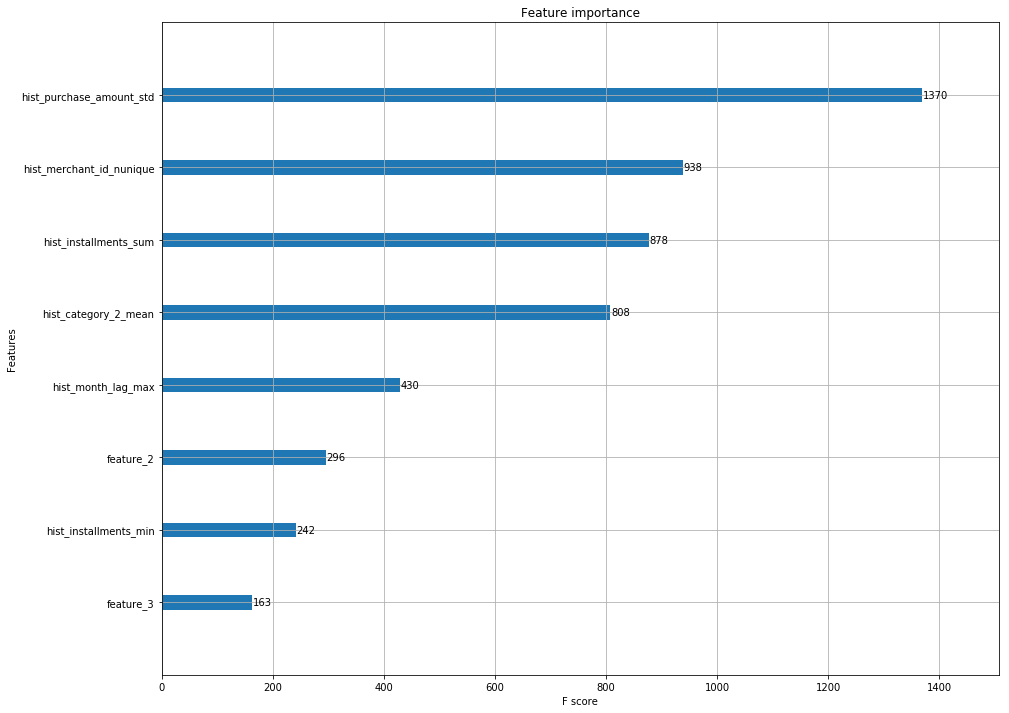

In [85]:
plt.rcParams['figure.figsize'] = [15, 12]
xgb.plot_importance(xg_reg)
plt.show()

In [122]:
submission2 = pd.DataFrame({"card_id":new_test["card_id"].values})
submission2["target"] = pd.DataFrame(preds_model1)
submission2 = submission2.fillna(np.median(submission2.target))

submission2 = submission2.iloc[0:123623]

In [123]:
submission2.to_csv('Elo_Submission2', index=False)

<h1><center>(Attempt 2)</center></h1> 

<h3><center>(All features from Aggregrate Groupby)</center></h3>

In [41]:
new_test.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'year', 'month', 'elapsed_time', 'hist_transactions_count',
       'hist_authorized_flag_sum', 'hist_authorized_flag_mean',
       'hist_merchant_id_nunique', 'hist_city_id_nunique',
       'hist_purchase_amount_sum', 'hist_purchase_amount_median',
       'hist_purchase_amount_max', 'hist_purchase_amount_min',
       'hist_purchase_amount_std', 'hist_installments_sum',
       'hist_installments_median', 'hist_installments_max',
       'hist_installments_min', 'hist_installments_std',
       'hist_purchase_date_ptp', 'hist_month_lag_min', 'hist_month_lag_max',
       'hist_category_1_sum', 'hist_category_1_mean', 'hist_category_2_sum',
       'hist_category_2_mean', 'hist_category_3_sum', 'hist_category_3_mean'],
      dtype='object')

In [42]:
new_train2 = new_train.drop(['first_active_month', 'card_id', 'target'], axis=1)
x_test_df = new_test.drop(['first_active_month', 'card_id'], axis=1)

In [43]:
x_test_df.shape

(123623, 30)

In [44]:
get_cv_rsme(new_train2, y_train)

[11:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[11:56:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
69,3.6872,0.029567,3.754296,0.062019


All applicable features.

<font color=green>**Test RSME score: 3.754**</font>

In [45]:
xg_reg.fit(new_train2, y_train)

preds = xg_reg.predict(x_test_df)

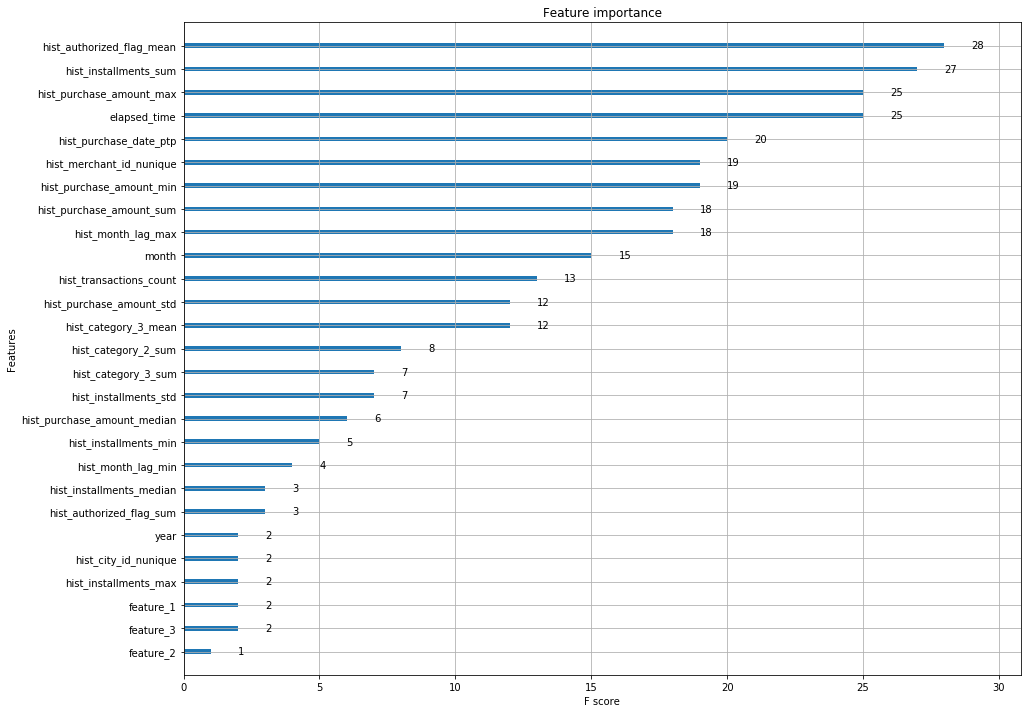

In [46]:
plt.rcParams['figure.figsize'] = [15, 12]
xgb.plot_importance(xg_reg)
plt.show()

<h1><center>(Attempt 3)</center></h1> 

<h3><center>(Solely Eliminating High VIF Features)</center></h3>

In [91]:
vif3 = pd.DataFrame()
vif3["VIF Factor"] = [variance_inflation_factor(new_train2.values, i) for i in range(new_train2.shape[1])]
vif3["features"] = new_train2.columns

C:\Users\Ameen\Miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [92]:
vif3.round(1)

,VIF Factor,features
0,1.7,feature_1
1,1.1,feature_2
2,1.9,feature_3
3,213.2,year
4,1.2,month
5,1.6,elapsed_time
6,397.0,hist_transactions_count
7,323.7,hist_authorized_flag_sum
8,1.7,hist_authorized_flag_mean
9,6.6,hist_merchant_id_nunique


In [93]:
low_vif_features = new_train2.drop(['year', 'hist_transactions_count', 'hist_authorized_flag_sum', 
                                    'hist_purchase_amount_sum', 'hist_purchase_amount_max', 
                                    'hist_purchase_amount_std', 'hist_purchase_date_ptp', 'hist_month_lag_min', 
                                    'hist_category_3_sum'], axis=1)

In [94]:
vif4 = pd.DataFrame()
vif4["VIF Factor"] = [variance_inflation_factor(low_vif_features.values, i) for i in range(low_vif_features.shape[1])]
vif4["features"] = low_vif_features.columns

C:\Users\Ameen\Miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1545: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [95]:
vif4.round(1)

,VIF Factor,features
0,13.1,feature_1
1,6.8,feature_2
2,4.3,feature_3
3,6.1,month
4,3.0,elapsed_time
5,48.3,hist_authorized_flag_mean
6,10.0,hist_merchant_id_nunique
7,6.3,hist_city_id_nunique
8,7.9,hist_purchase_amount_median
9,42.8,hist_purchase_amount_min


In [96]:
lower_vif_features = low_vif_features.drop(['feature_1', 'hist_authorized_flag_mean', 'hist_merchant_id_nunique',
                                            'hist_purchase_amount_min', 'hist_category_3_mean'], axis=1)

In [97]:
vif5 = pd.DataFrame()
vif5["VIF Factor"] = [variance_inflation_factor(lower_vif_features.values, i) for i in range(lower_vif_features.shape[1])]
vif5["features"] = lower_vif_features.columns

C:\Users\Ameen\Miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1545: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [98]:
vif5.round(1)

,VIF Factor,features
0,5.8,feature_2
1,2.5,feature_3
2,5.0,month
3,2.8,elapsed_time
4,3.6,hist_city_id_nunique
5,4.7,hist_purchase_amount_median
6,2.6,hist_installments_sum
7,4.7,hist_installments_median
8,4.6,hist_installments_max
9,5.4,hist_installments_min


In [99]:
get_cv_rsme(lower_vif_features, y_train) #All features with lower vif values

[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[14:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[14:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[14:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[14:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
69,3.764291,0.032225,3.804532,0.066595


Solely removed features with very high VIF values, thus creating a simpler model with less variation.

### <font color=green>**Test RSME score: 3.80**</font>

In [107]:
test_lowervif = x_test_df[lower_vif_features.columns.values]

In [165]:
stats.mode(submission3.target)

ModeResult(mode=array([0.01880816], dtype=float32), count=array([897]))

In [166]:
xg_reg.fit(lower_vif_features,y_train)

preds_model2 = xg_reg.predict(test_lowervif)

submission3 = pd.DataFrame({"card_id":new_test["card_id"].values})
submission3["target"] = pd.DataFrame(preds_model2)
submission3 = submission2.fillna(0.01880816)

submission3 = submission3.iloc[0:123623]

In [167]:
submission3.to_csv('Elo_Submission3', index=False) #Scored 3.921, not an improvement

<h1><center>(Attempt 4)</center></h1> 

<h3><center>(Applying Principal Component Analysis (PCA))</center></h3>

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [54]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)

pipeline.fit(new_train2)

C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [55]:
features = range(pca.n_components_)

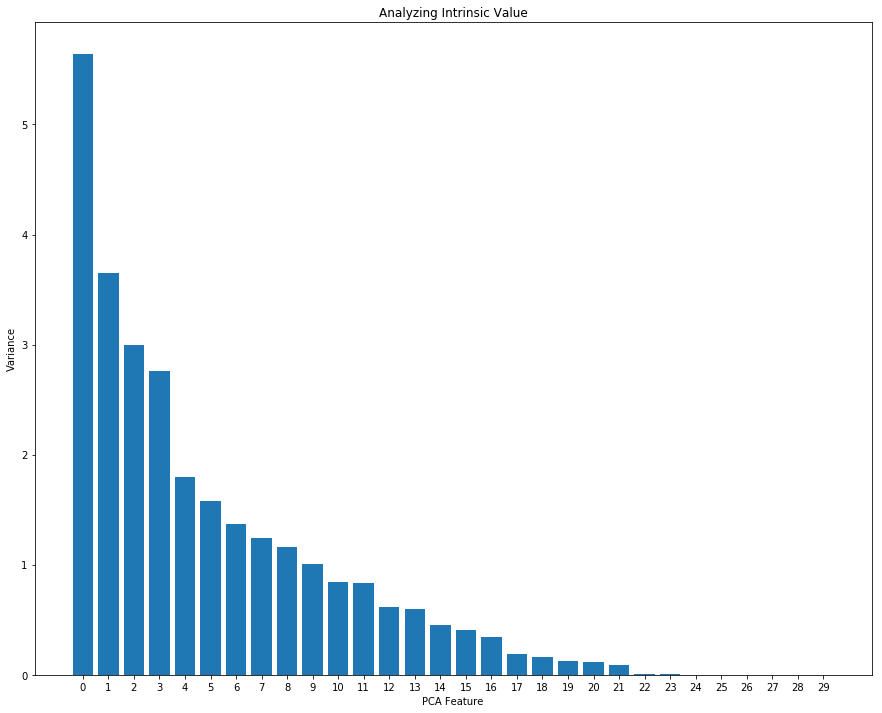

In [56]:
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.title('Analyzing Intrinsic Value')
plt.show()

#### The data contains an intrinsic value of 4. A new pipeline will be created to reduce the dimensions with 4 components

In [57]:
pca2 = PCA(n_components=4) #Set components to 4
pipeline2 = make_pipeline(scaler, pca2) # Build a new pipeline

pipeline2.fit(new_train2) #Fit the features
pca_features = pipeline2.transform(new_train2) #Transform the data

C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [58]:
pca_features.shape #The PCA features has 4 columns as expected

(197615, 4)

In [59]:
y_train.shape # As desired the two have the same rows

(197615,)

In [60]:
get_cv_rsme(pca_features, y_train)

[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:57:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[11:57:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_

[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[11:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
34,3.79816,0.033866,3.819613,0.067645


**Scaling the data, applying PCA, determining the intrinsic value (number of features needed to apppoximate the dataset),
and limiting the components to that value, worsened the test rsme score.**

In numerious attempts to modify the number of components, the more components I allowed, the lower RSME score I acheived, but would be causing ovefitting.

### <font color=green>**Test RSME score: 3.82**</font>

In [146]:
test_pca = pipeline2.fit_transform(x_test_df.dropna())

C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ameen\Miniconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [132]:
pca_prediction.shape

(120981,)

In [147]:
xg_reg.fit(pca_features, y_train)

pca_prediction = xg_reg.predict(test_pca)

submission4 = pd.DataFrame({"card_id":new_test["card_id"].values})
submission4["target"] = pd.DataFrame(pca_prediction)

In [161]:
stats.mode(submission4.target)

ModeResult(mode=array([-0.3107276], dtype=float32), count=array([198]))

In [162]:
submission4 = submission4.fillna(-.3107276)

submission4 = submission4.iloc[0:123623]

In [163]:
submission4.to_csv('Elo_Submission4', index=False) #Scored 4.224, not an improvement

<h1><center>(Attempt 5)</center></h1> 

<h3><center>(Optimizing Parameters)</center></h3>

In this initial attempt I aimed to use GridSearch to optimize the parameters, but seeing how much time is required to compute this, I settled for good old trial and error to get some optimal parameters. Alternatively I could have tried RandomSearchCV.

In [61]:
def rsme_params(Features, Target, Parameters): # Same as my get_rsme function, but with an extra input to 
                                               # allow different parameters to test out
    
    data_dmatrix = xgb.DMatrix(data=Features,label=Target) #Improves the performance and efficiency of the model

    cv_results = xgb.cv(dtrain=data_dmatrix, params=Parameters, nfold=3,
                    num_boost_round=70,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)
    
    return(cv_results.tail(1))

# Same as my get_rsme function, but with an extra input to allow different parameters to test out

In [62]:
params1 = {'n_estimators': 500, 'max_depth': 5,
              'learning_rate' : .05, 'subsample' : .9,
              'colsample_bytree' : .5,
              'gamma' : 1 }

# Base parameter choices

In [63]:
params2 = {'n_estimators': 100, 'max_depth': 6,
              'learning_rate' : .07, 'subsample' : .92,
              'colsample_bytree' : .5,
              'gamma' : 1 }
#Final results after trial and error based off reccomended values for each of these important parameters for XGB

* changing n_estimators had no effect
* decreasing max_depth worsened the score
* Increasing max_depth significantly worsened the score on the test, but greatly could reduce the score on the
  training set. Hence, causing overfitting. 6 found to be optimal value. Keeping the model simple and avoiding overfitting
* Optimal learning rate found to be .07
* Increasing subsample to .92, which is the % of rows taken to build a tree, negligibly raised the score
* Got the column sample per tree, and gamma (a regularization parameter), 
  right on the money the first time with .5 and 1 respectively

In [64]:
rsme_params(new_train2, y_train, params1) #With base set of parameters

[11:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[11:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[11:57:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[11:57:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[11:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
69,3.709595,0.030711,3.752615,0.063777


In [285]:
rsme_params(new_train2, y_train, params2) # With optimally found paramters

[03:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[03:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[03:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[03:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[03:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=6
[03:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[03:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[03:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[03:45:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned no

[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 2 pruned nodes, max_depth=6
[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 2 pruned nodes, max_depth=6
[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 2 pruned nodes, max_depth=6
[03:46:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[03:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nod

[03:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 4 pruned nodes, max_depth=6
[03:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 4 pruned nodes, max_depth=6
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 2 pruned nodes, max_depth=6
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 2 pruned nodes, max_depth=6
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
69,3.633357,0.030552,3.745091,0.061466


All applicable features + optimized hyperparamters

<font color=crimson>**Test RSME score:<h2> 3.745**</h2></font>

<h1><center>Conclusion</center></h1> 

***

Including all the features created by the groupby function, **aggregrate_historical_transactions**, did improve the RMSE score on the test set. Interestingly limiting the features through various feature engineering techniques resulted in a  worsened RMSE score on the cross validation set, but indefintely had caused overfitting, as proved when I submitted these model predictions to the kaggle competition and I received a low score. So they wouldn't be a good method to use for real world applications. A more accurate model during training is not always the better model for production. <br>

In my analysis I've come to the conclusion that the data available predicting the loyalty score for the Brazilian payment company is insufficient to make any accurate predictions for their customer base. My RMSE score of 3.745 on the test set, or 3.921 on the unseen test target values, would not be helpful due to how inaccurate the model is with the available features. The several attempts and optimization of hyperparameters only helped to boost my placement on Kaggle, but the range of my score, as well as others that can be seen on the __[competition leaderboard](https://www.kaggle.com/c/elo-merchant-category-recommendation/leaderboard)__ would most likely be inapplicable to a business setting.<br>

The majority of the target values lie between -1 and 1, so if the prediction is off by 3.75 more or less, the prediction is not something that can be utilized.

I assumed throughout the analysis that the -33 loyalty score was based off a high amount of flagged authorizations. The feature importance graph on attempt 2 shows the most important feature as hist_aurthoized_flag_mean (the mean of a users transactions that were properly authorized). This suggests the model is likely correctly predicting if a customers loyalty score is -33 or not, accurately. Hence the high RMSE score. <br>

This analysis might not bring real value, and may be labeled not feasible, but thats okay! That is part of data science work. Sometimes you find you don't have what you need to accomplish an objective, and you need to go back to acquire more meaningful data. The hypothesis might be proved wrong, and thats part of the job in any science releted field. In a business setting, domain knowlede and stakeholder input is a vital step to determining if you are asking the right questions. The data scientist needs to determine if that data is currently in our possession, and if not, investigate how it can be obtained, whether through surverys, webscraping or other means.' <br>

**Onward to the next challenge! :)**

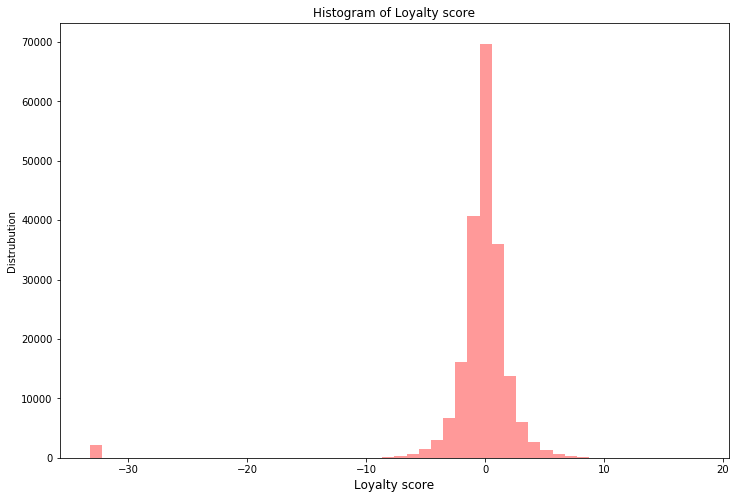

In [292]:
plt.figure(figsize=(12,8))
sns.distplot(train.target.values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel('Loyalty score', fontsize=12)
plt.ylabel('Distrubution')
plt.show()